sources:

https://graphframes.github.io/graphframes/docs/_site/user-guide.html

https://docs.databricks.com/_static/notebooks/graphframes-user-guide-py.html

https://towardsdatascience.com/graphframes-in-jupyter-a-practical-guide-9b3b346cebc5

https://graphframes.github.io/graphframes/docs/_site/api/python/index.html

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from IPython.display import display, HTML

import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *
from graphframes import *

In [2]:
# https://graphframes.github.io/graphframes/docs/_site/quick-start.html
# https://stackoverflow.com/questions/65011599/how-to-start-graphframes-on-spark-on-pyspark-on-juypter-on-docker
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell'

In [3]:
# Start Spark context
spark = SparkSession.builder.appName('graphx-network-analysis').getOrCreate()

21/10/21 19:08:30 WARN Utils: Your hostname, mark-machine resolves to a loopback address: 127.0.1.1; using 192.168.0.102 instead (on interface wlp8s0)
21/10/21 19:08:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mark/.ivy2/cache
The jars for the packages stored in: /home/mark/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-026eb474-c130-491c-9701-e2e0f363b705;1.0
	confs: [default]
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 147ms :: artifacts dl 6ms
	:: modules in use:
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-------------------------------------

In [4]:
%%bash
file=./data/amazon0302.txt.gz
file_meta=./data/amazon-meta.txt.gz

if [ -e "$file" ]; then
    echo "$file exists, skipping"
else 
    echo "$file does not exist, using wget to download it"
    wget http://snap.stanford.edu/data/amazon0302.txt.gz -P data/
    gzip -dkfv $file
fi

if [ -e "$file_meta" ]; then
    echo "$file_meta exists, skipping"
else 
    echo "$file_meta does not exist, using wget to download it"
    wget http://snap.stanford.edu/data/amazon0302.txt.gz -P data/
    gzip -dkfv $file_meta
fi

./data/amazon0302.txt.gz exists, skipping
./data/amazon-meta.txt.gz exists, skipping


In [5]:
def read_data(from_file_name, exclude_meta=True):
    df_edges = pd.read_csv(from_file_name, sep="\t", header=None, skiprows=4, names=["src", "dst"])
    vertices_np = \
        np.unique(np.hstack([df_edges["src"].unique(), df_edges["dst"].unique()]))
    
    df_vertices = pd.DataFrame(data={"id": vertices_np})
    
    return df_edges, df_vertices
    
from_file_name = "data/amazon0302.txt"
df_edges, df_vertices = read_data(from_file_name=from_file_name)

In [6]:
def read_meta(from_file_name):
    if_id = False
    id_ = None
    if_title = False
    title = None
    if_group = False
    group = None
    if_salesrank = False
    salesrank = None
    if_reviews = False
    reviews = None

    def if_all_cols():
        return if_id and if_title and if_group and if_salesrank and if_reviews
    
    cols = ["id", "title", "group", "salesrank", "reviews"]
    
    discontinued_prodcut_str = "discontinued product"
    
    from_file_name = "data/amazon-meta.txt"
    
    records = []
    
    with open(from_file_name, "r") as file:
        lines = file.readlines()[2:]
        
        length = len(lines)
        idx = 0
        
        for idx in tqdm(range(len(lines)), file=sys.stdout):
            line = lines[idx]
            
            
            try:
                if_discontinued_str = lines[idx+3].strip()
            
            except Exception:
                break
            else:
                if if_discontinued_str == discontinued_prodcut_str:
                    idx += 4
                else:
                    line_proc = line.strip().lower()
                    
                    line_proc_split = line_proc.split(":")
                    col = line_proc_split[0]
                    if col == "id":
                        id_ = int(line_proc_split[1].strip())
                        if_id = True
                        
                    if col == "title":
                        title = line.split("title:")[1].strip()
                        if_title = True
                    
                    if col == "group":
                        group = line_proc_split[1].strip()
                        if_group = True
                    
                    if col == "salesrank":
                        salesrank = int(line_proc_split[1].strip())
                        if_salesrank = True
                        
                    if col == "reviews":
                        reviews = float(line.split('avg rating:')[-1].strip())
                        if_reviews = True
                    
                    if if_all_cols():
                        
                        records.append({
                            "id": id_,
                            "title": title,
                            "group": group,
                            "salesrank": salesrank,
                            "reviews": reviews
                        })
                        
                        if_id = False
                        id_ = None
                        if_title = False
                        title = None
                        if_group = False
                        group = None
                        if_salesrank = False
                        salesrank = None
                        if_reviews = False
                        reviews = None
                    
                    idx += 1
            
                
            
    return pd.DataFrame(data=records)
        
from_file_name = "data/amazon-meta.txt"
df_meta = read_meta(from_file_name=from_file_name)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 15010569/15010572 [00:14<00:00, 1006840.18it/s]


In [7]:
display(HTML(df_edges.head(10).to_html()))
display(HTML(df_vertices.head(10).to_html()))
display(HTML(df_meta.head(10).to_html()))

,src,dst
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,1,0
6,1,2
7,1,4
8,1,5
9,1,15


,id
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


,id,title,group,salesrank,reviews
0,1,Patterns of Preaching: A Sermon Sampler,book,396585,5.0
1,2,Candlemas: Feast of Flames,book,168596,4.5
2,3,World War II Allied Fighter Planes Trading Cards,book,1270652,5.0
3,4,Life Application Bible Commentary: 1 and 2 Timothy and Titus,book,631289,4.0
4,5,Prayers That Avail Much for Business: Executive,book,455160,0.0
5,6,How the Other Half Lives: Studies Among the Tenements of New York,book,188784,4.0
6,7,Batik,music,5392,4.5
7,8,Losing Matt Shepard,book,277409,4.5
8,9,Making Bread: The Taste of Traditional Home-Baking,book,949166,0.0
9,10,The Edward Said Reader,book,220379,4.0


In [8]:
# could take 1 min
vertices_no_meta = spark.createDataFrame(df_vertices, list(df_vertices.columns.values))
edges = spark.createDataFrame(df_edges, list(df_edges.columns.values))
meta = spark.createDataFrame(df_meta, list(df_meta.columns.values))

In [9]:
vertices = \
    vertices_no_meta.\
    join(meta, vertices_no_meta["id"] == meta["id"], "inner").\
    drop(meta.id)

vertices.show()

21/10/21 19:09:31 WARN TaskSetManager: Stage 1 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+----+--------------------+-----+---------+-------+
|  id|               title|group|salesrank|reviews|
+----+--------------------+-----+---------+-------+
|  26|      Chicken Little| book|   242571|    4.0|
|  29|Advanced Pediatri...| book|   677416|    0.0|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
| 964|Outsmarting the S...| book|   536872|    4.5|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|1697|Experiences in Mo...| book|   695386|    0.0|
|1806|Black Stallion an...| book|    71706|    5.0|
|1950|Applied Blood Gro...| book|   985020|    5.0|
|2040|The Minority Repo...| book|   326911|    4.5|
|2214|The Arts of the S...| book|   923205|    4.0|
|2250|         Yummy Yummy|music|   170306|    4.5|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|2509|Girls, Delinquenc...| book|   559169|    5.0|
|2529|When You look Lik...| book|   667405|    5.0|
|2927|The Art of Outdoo...| book|   299959|    4.5|
|3091|Blue Moon Cat: Li...|music|   379772|    2.0|
|3506|Fire o

In [10]:
g = GraphFrame(vertices, edges)

In [11]:
g.vertices.show()
g.edges.show()

21/10/21 19:09:32 WARN TaskSetManager: Stage 3 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+----+--------------------+-----+---------+-------+
|  id|               title|group|salesrank|reviews|
+----+--------------------+-----+---------+-------+
|  26|      Chicken Little| book|   242571|    4.0|
|  29|Advanced Pediatri...| book|   677416|    0.0|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
| 964|Outsmarting the S...| book|   536872|    4.5|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|1697|Experiences in Mo...| book|   695386|    0.0|
|1806|Black Stallion an...| book|    71706|    5.0|
|1950|Applied Blood Gro...| book|   985020|    5.0|
|2040|The Minority Repo...| book|   326911|    4.5|
|2214|The Arts of the S...| book|   923205|    4.0|
|2250|         Yummy Yummy|music|   170306|    4.5|
|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|2509|Girls, Delinquenc...| book|   559169|    5.0|
|2529|When You look Lik...| book|   667405|    5.0|
|2927|The Art of Outdoo...| book|   299959|    4.5|
|3091|Blue Moon Cat: Li...|music|   379772|    2.0|
|3506|Fire o

21/10/21 19:09:33 WARN TaskSetManager: Stage 6 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


In [12]:
print((g.vertices.count(), len(g.vertices.columns)))
print((g.edges.count(), len(g.edges.columns)))

21/10/21 19:09:34 WARN TaskSetManager: Stage 8 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


(259168, 5)


21/10/21 19:09:36 WARN TaskSetManager: Stage 11 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


(1234877, 2)


In [13]:
g.degrees.show()
g.inDegrees.show()
g.outDegrees.show()

21/10/21 19:09:37 WARN TaskSetManager: Stage 13 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:38 WARN TaskSetManager: Stage 15 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+----+------+
|  id|degree|
+----+------+
|  26|    17|
|  29|    45|
| 474|     4|
|1677|    13|
|1697|     7|
| 964|    13|
|1806|    18|
|1950|     9|
|2453|     8|
|3091|     8|
|2040|     6|
|3506|    15|
|2214|    24|
|2250|     9|
|5385|     9|
|7225|    13|
|2509|     6|
|5409|    14|
|2529|    18|
|2927|     7|
+----+------+
only showing top 20 rows



21/10/21 19:09:39 WARN TaskSetManager: Stage 17 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+----+--------+
|  id|inDegree|
+----+--------+
|  26|      12|
|  29|      40|
| 474|       4|
|1677|       8|
|1697|       2|
| 964|       8|
|1806|      13|
|1950|       4|
|2453|       3|
|3091|       3|
|2040|       1|
|3506|      10|
|2214|      19|
|2250|       4|
|5385|       4|
|7225|       8|
|2509|       1|
|5409|       9|
|2529|      13|
|2927|       2|
+----+--------+
only showing top 20 rows

+----+---------+
|  id|outDegree|
+----+---------+
|  26|        5|
|  29|        5|
| 964|        5|
|1677|        5|
|1697|        5|
|1806|        5|
|1950|        5|
|2040|        5|
|2214|        5|
|2250|        5|
|2453|        5|
|2509|        5|
|2529|        5|
|2927|        5|
|3091|        5|
|3506|        5|
|3764|        5|
|4590|        5|
|4823|        5|
|4894|        5|
+----+---------+
only showing top 20 rows



21/10/21 19:19:28 WARN TaskSetManager: Stage 537 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


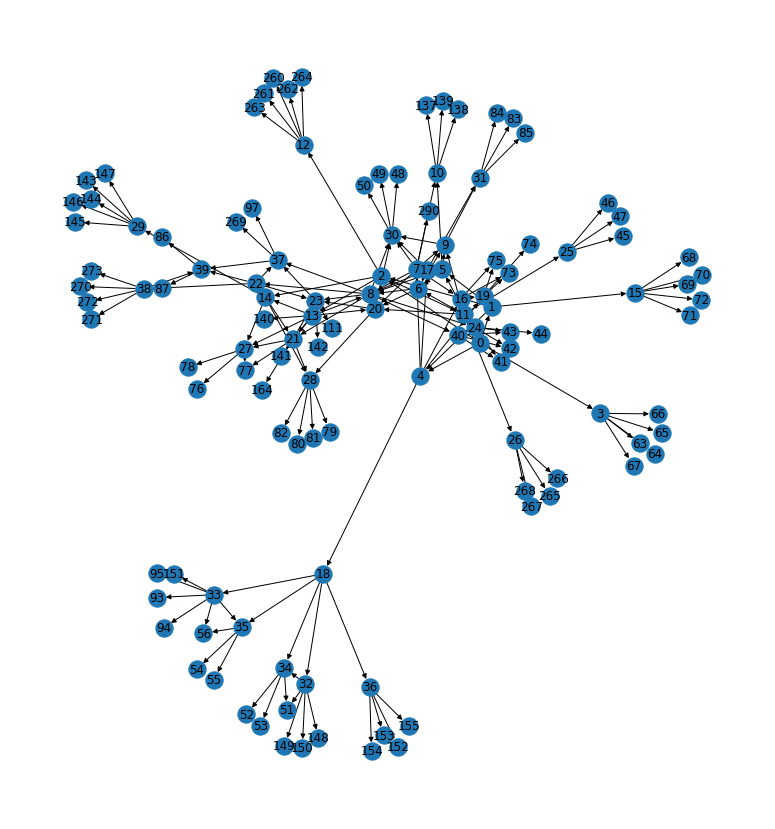

In [37]:
def plot_graph(edges, path_fig=None, take_n=300):
    Gplot=nx.Graph()
    for row in edges.select("src", "dst").take(take_n):
        Gplot.add_edge(row["src"],row["dst"])

    plt.figure(figsize=(30,15))
    plt.subplot(121)
    nx.draw(Gplot, with_labels=True, arrows=True)
    
    if path_fig is not None:
        plt.savefig(path_fig)
    else:
        pass

take_n = 200
path_fig = f"assets/graph_viz_n_{take_n}.png"
plot_graph(g.edges, path_fig=path_fig, take_n=take_n)

In [15]:
g.degrees.show()

21/10/21 19:09:41 WARN TaskSetManager: Stage 20 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+----+------+
|  id|degree|
+----+------+
|  26|    17|
|  29|    45|
| 474|     4|
|1677|    13|
|1697|     7|
| 964|    13|
|1806|    18|
|1950|     9|
|2453|     8|
|3091|     8|
|2040|     6|
|3506|    15|
|2214|    24|
|2250|     9|
|5385|     9|
|7225|    13|
|2509|     6|
|5409|    14|
|2529|    18|
|2927|     7|
+----+------+
only showing top 20 rows



In [16]:
from pyspark.sql.functions import desc

g.degrees.sort(desc("degree")).show()
g.degrees.sort(desc("degree")).show()

21/10/21 19:09:42 WARN TaskSetManager: Stage 22 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:43 WARN TaskSetManager: Stage 24 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+
|   id|degree|
+-----+------+
|14949|   425|
| 4429|   409|
|   33|   366|
|10519|   339|
|12771|   335|
|    8|   298|
|  297|   280|
|  481|   280|
| 5737|   277|
| 9106|   232|
| 8939|   226|
|   93|   224|
| 1241|   223|
| 5765|   214|
| 2501|   196|
|   99|   193|
| 3661|   186|
| 2353|   184|
|  244|   184|
|17525|   180|
+-----+------+
only showing top 20 rows



+-----+------+
|   id|degree|
+-----+------+
|14949|   425|
| 4429|   409|
|   33|   366|
|10519|   339|
|12771|   335|
|    8|   298|
|  297|   280|
|  481|   280|
| 5737|   277|
| 9106|   232|
| 8939|   226|
|   93|   224|
| 1241|   223|
| 5765|   214|
| 2501|   196|
|   99|   193|
| 3661|   186|
| 2353|   184|
|  244|   184|
|17525|   180|
+-----+------+
only showing top 20 rows



In [17]:
degrees_df = \
    g.degrees.\
    join(g.inDegrees, g.degrees["id"] == g.inDegrees["id"], "outer").\
    join(g.outDegrees, g.degrees["id"] == g.outDegrees["id"], "outer").\
    drop(g.outDegrees.id).\
    drop(g.inDegrees.id).\
    na.fill(0)

degrees_df.sort(desc("degree")).show()

21/10/21 19:09:45 WARN TaskSetManager: Stage 26 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:45 WARN TaskSetManager: Stage 27 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:46 WARN TaskSetManager: Stage 28 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+--------+---------+
|   id|degree|inDegree|outDegree|
+-----+------+--------+---------+
|14949|   425|     420|        5|
| 4429|   409|     404|        5|
|   33|   366|     361|        5|
|10519|   339|     334|        5|
|12771|   335|     330|        5|
|    8|   298|     293|        5|
|  481|   280|     275|        5|
|  297|   280|     280|        0|
| 5737|   277|     272|        5|
| 9106|   232|     227|        5|
| 8939|   226|     221|        5|
|   93|   224|     219|        5|
| 1241|   223|     218|        5|
| 5765|   214|     209|        5|
| 2501|   196|     191|        5|
|   99|   193|     188|        5|
| 3661|   186|     181|        5|
| 2353|   184|     179|        5|
|  244|   184|     179|        5|
|17525|   180|     175|        5|
+-----+------+--------+---------+
only showing top 20 rows



In [18]:
degrees_list = [int(d.degree) for d in degrees_df.select('degree').collect()]
in_degree_list = [int(d.inDegree) for d in degrees_df.select('inDegree').collect()]
out_degree_list = [int(d.outDegree) for d in degrees_df.select('outDegree').collect()]

21/10/21 19:09:49 WARN TaskSetManager: Stage 31 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:49 WARN TaskSetManager: Stage 32 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:50 WARN TaskSetManager: Stage 33 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:54 WARN TaskSetManager: Stage 36 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:55 WARN TaskSetManager: Stage 37 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:55 WARN TaskSetManager: Stage 39 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:09:58 WARN TaskSetManager: Stage 41 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/

In [19]:
def plot_n_nodes_vs_degree(x, n_bins, x_step, yscale, ylabel, xlabel, title, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.hist(x, bins=n_bins)
    assert yscale in ["log", "linear"]
    plt.yscale(yscale)
    plt.grid("on")
    plt.xticks(np.arange(min(x)-1, max(x)+x_step, x_step))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    
    if save_path is not None:
        plt.savefig(save_path)
    else:
        pass
    
    plt.show()

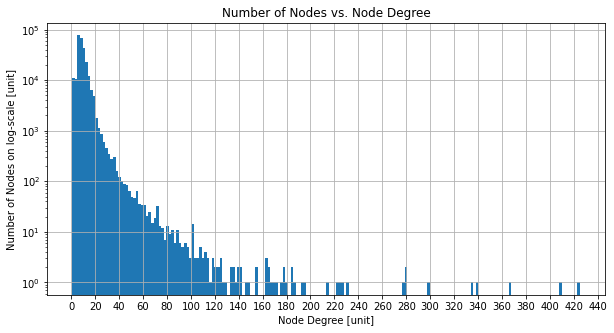

In [20]:
x = degrees_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Degree [unit]"
title = "Number of Nodes vs. Node Degree"
save_path = "assets/n_nodes_vs_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

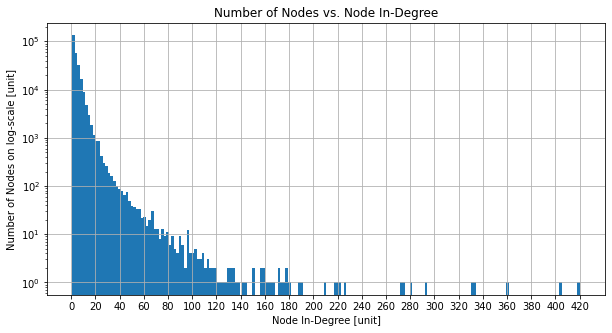

In [21]:
x = in_degree_list
n_bins = 200
x_step = 20
yscale = "log"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node In-Degree [unit]"
title = "Number of Nodes vs. Node In-Degree"
save_path = "assets/n_nodes_vs_in_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

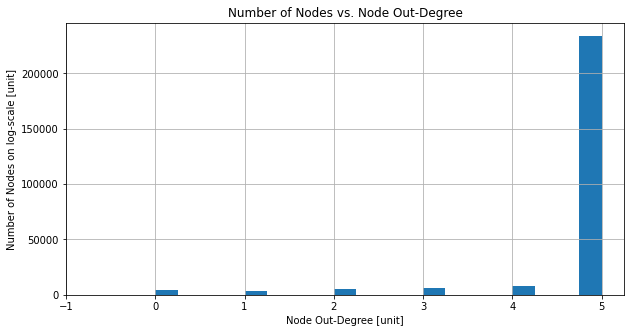

In [22]:
x = out_degree_list
n_bins = 20
x_step = 1
yscale = "linear"
ylabel = "Number of Nodes on log-scale [unit]"
xlabel = "Node Out-Degree [unit]"
title = "Number of Nodes vs. Node Out-Degree"
save_path = "assets/n_nodes_vs_out_degree.png"

plot_n_nodes_vs_degree(
    x=x, 
    n_bins=n_bins, 
    x_step=x_step,
    yscale=yscale,
    ylabel=ylabel, 
    xlabel=xlabel, 
    title=title, 
    save_path=save_path)

In [23]:
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

21/10/21 19:10:07 WARN TaskSetManager: Stage 47 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:08 WARN TaskSetManager: Stage 49 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:12 WARN TaskSetManager: Stage 53 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+--------------------+------------+
|                   a|           e|                   b|          e2|
+--------------------+------------+--------------------+------------+
|{19, Ultimate Mar...|     {19, 4}|{4, Life Applicat...|     {4, 19}|
|{96, Becoming a C...|    {96, 56}|{56, Three Bricks...|    {56, 96}|
|{90, The Eagle Ha...|   {90, 172}|{172, Cherokee Ba...|   {172, 90}|
|{198, Imitation o...|  {198, 232}|{232, Review of V...|  {232, 198}|
|{266, Antique Gol...|  {266, 267}|{267, Unwinnable ...|  {267, 266}|
|{1187, Jedit (Leg...| {1187, 453}|{453, The Insider...| {453, 1187}|
|{1690, What If, b...| {1690, 511}|{511, Business St...| {511, 1690}|
|{166, In the Arms...|  {166, 619}|{619, Testifyin'!...|  {619, 166}|
|{560, Simply Gran...|  {560, 814}|{814, Ev'Ry Time ...|  {814, 560}|
|{1796, Craig Shoe...| {1796, 849}|{849, Toxics A to...| {849, 1796}|
|{1385, Inimitable...| {1385, 953}|{953, El devocion...| {953, 1385}|
|{2637, Footprint ..

In [24]:
# b is mutually copurchased with a and c
mutually_copurchased_products_df = g.find("(a)-[]->(mutual); (mutual)-[]->(c); (c)-[]->(mutual); (mutual)-[]->(a)").dropDuplicates()
mutually_copurchased_products_df.show()

21/10/21 19:10:17 WARN TaskSetManager: Stage 66 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:17 WARN TaskSetManager: Stage 55 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:18 WARN TaskSetManager: Stage 58 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:22 WARN TaskSetManager: Stage 61 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:27 WARN TaskSetManager: Stage 65 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+--------------------+
|                   a|              mutual|                   c|
+--------------------+--------------------+--------------------+
|{3656, Trouble wi...|{2777, Starting W...|{2773, The Diabet...|
|{20006, GIRLS TO ...|{21752, The Hidde...|{39066, Pagan Kid...|
|{29655, How to Dr...|{22965, The Exist...|{29653, Cape May ...|
|{32555, Macromedi...|{32557, All the R...|{32556, Comigo - ...|
|{52531, Live Psal...|{38877, Red Smith...|{52532, An Atlas ...|
|{108011, Eyewitne...|{41110, A Perfect...|{108011, Eyewitne...|
|{43387, Samoyed C...|{43388, John D. R...|{48744, In My Lif...|
|{80655, Relativit...|{44094, Magic Mir...|{24749, Disintegr...|
|{68477, The Shy C...|{44472, Race, Cla...|{68477, The Shy C...|
|{40398, Poem of t...|{47306, What's Co...|{61235, An Elusiv...|
|{50857, Sair Linu...|{50859, Brian's S...|{50858, Don't Die...|
|{48241, The Sunsh...|{65144, Sun Kisse...|{65145, Live Set,...|
|{63877, Coral Fis...|{71

In [25]:
g.triangleCount().show()

21/10/21 19:10:45 WARN TaskSetManager: Stage 70 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:45 WARN TaskSetManager: Stage 71 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:51 WARN TaskSetManager: Stage 77 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:10:58 WARN TaskSetManager: Stage 81 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+-----+----+--------------------+-----+---------+-------+
|count|  id|               title|group|salesrank|reviews|
+-----+----+--------------------+-----+---------+-------+
|   19|  26|      Chicken Little| book|   242571|    4.0|
|   48|  29|Advanced Pediatri...| book|   677416|    0.0|
|    0| 474|Bad Aboriginal Ar...| book|   714825|    5.0|
|    2| 964|Outsmarting the S...| book|   536872|    4.5|
|   17|1677|Robert Louis Stev...|  dvd|    26035|    4.0|
|    1|1697|Experiences in Mo...| book|   695386|    0.0|
|   24|1806|Black Stallion an...| book|    71706|    5.0|
|   10|1950|Applied Blood Gro...| book|   985020|    5.0|
|    6|2040|The Minority Repo...| book|   326911|    4.5|
|   21|2214|The Arts of the S...| book|   923205|    4.0|
|    6|2250|         Yummy Yummy|music|   170306|    4.5|
|    3|2453|  Gourmet Paris 2002| book|   900117|    5.0|
|    4|2509|Girls, Delinquenc...| book|   559169|    5.0|
|   23|2529|When You look Lik...| book|   667405|    5.0|
|    4|2927|Th

In [26]:
pr = g.pageRank(resetProbability=0.15, maxIter=10)
## look at the pagerank score for every vertex
#pr.vertices.show()
## look at the weight of every edge
#pr.edges.show()
## pagrank descending
pr.vertices.orderBy("pagerank", ascending=False).show()

21/10/21 19:11:02 WARN TaskSetManager: Stage 85 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:05 WARN TaskSetManager: Stage 83 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:06 WARN TaskSetManager: Stage 86 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:15 WARN TaskSetManager: Stage 90 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:18 WARN TaskSetManager: Stage 92 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:18 WARN TaskSetManager: Stage 102 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:19 WARN TaskSetManager: Stage 104 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/1

+----+--------------------+-----+---------+-------+------------------+
|  id|               title|group|salesrank|reviews|          pagerank|
+----+--------------------+-----+---------+-------+------------------+
|  33|Double Jeopardy (...| book|    97166|    5.0|303.58111087285306|
|  93|BizPricer¿ Busine...| book|  1485593|    0.0|269.32783595836105|
|   8| Losing Matt Shepard| book|   277409|    4.5| 225.8263182478711|
|  94|The American Heri...| book|   166549|    4.0| 219.0304837562053|
|2501|The Narcissistic ...| book|     9727|    5.0|211.37991673953005|
|4429|Harley-Davidson P...| book|   147799|    4.5|202.63908289102554|
|  56|Three Bricks Shy ...| book|  2167012|    0.0|190.22280992057955|
|  95|The Heavy Flak Gu...| book|  1369585|    0.0|187.62095486637583|
| 151|Laurel & Hardy - ...|  dvd|    44671|    3.0| 182.9410781635186|
|2353|           Committed|music|   437762|    5.0|166.59436027895453|
|  23|Strange Fire: A N...| book|  1277867|    3.0|141.19379729540964|
| 429|

In [27]:
communities = g.labelPropagation(maxIter=1)
communities.persist().show()

21/10/21 19:11:37 WARN TaskSetManager: Stage 363 contains a task of very large size (1696 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:46 WARN TaskSetManager: Stage 374 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 19:11:51 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 19:11:51 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 19:11:51 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 19:11:51 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 19:11:51 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 19:11:51 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
21/10/21 19:11:51 WARN ShippableVert

+----+--------------------+-----+---------+-------+-----+
|  id|               title|group|salesrank|reviews|label|
+----+--------------------+-----+---------+-------+-----+
|  26|      Chicken Little| book|   242571|    4.0|   11|
|  29|Advanced Pediatri...| book|   677416|    0.0|  146|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|14266|
| 964|Outsmarting the S...| book|   536872|    4.5| 2635|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0| 4026|
|1697|Experiences in Mo...| book|   695386|    0.0|  319|
|1806|Black Stallion an...| book|    71706|    5.0| 2601|
|1950|Applied Blood Gro...| book|   985020|    5.0| 1207|
|2040|The Minority Repo...| book|   326911|    4.5| 1776|
|2214|The Arts of the S...| book|   923205|    4.0| 2111|
|2250|         Yummy Yummy|music|   170306|    4.5|10381|
|2453|  Gourmet Paris 2002| book|   900117|    5.0| 1483|
|2509|Girls, Delinquenc...| book|   559169|    5.0| 2384|
|2529|When You look Lik...| book|   667405|    5.0| 2475|
|2927|The Art 

In [28]:
communities.select("label").distinct().show()
print(communities.select("label").distinct().count())

+------+
| label|
+------+
| 42852|
| 36103|
| 36102|
| 28078|
|153306|
|161736|
|209614|
|213855|
|242382|
| 41862|
|106100|
|113699|
|167617|
| 56309|
|118448|
|122127|
| 66512|
|114458|
|207209|
|206745|
+------+
only showing top 20 rows



143264


In [38]:
def recommend1(communities, id_):
    selected_row = communities.filter(f"id == {id_}")
    selected_row.show()
    
    label = selected_row.select("label").collect()[0]["label"]
    recommendations = communities.filter(f"label == {label}")
    recommendations.show()
    
    return recommendations
    
id_ = 10
recommend1(communities=communities, id_=id_)

+---+--------------------+-----+---------+-------+-----+
| id|               title|group|salesrank|reviews|label|
+---+--------------------+-----+---------+-------+-----+
| 10|The Edward Said R...| book|   220379|    4.0|  137|
+---+--------------------+-----+---------+-------+-----+

+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
|  139|  The Sacred Impulse| book|   846457|    3.0|  137|
|  138|The McClurkin Pro...|music|    54277|    4.0|  137|
|   10|The Edward Said R...| book|   220379|    4.0|  137|
|47935| Classic Motorcycles| book|  1184165|    0.0|  137|
+-----+--------------------+-----+---------+-------+-----+



DataFrame[id: bigint, title: string, group: string, salesrank: bigint, reviews: double, label: bigint]

In [70]:
class LabelPropagationPredictor():
    def __init__(self, g, max_iter):
        self.max_iter = max_iter
        self.communities = g.labelPropagation(maxIter=self.max_iter)
        print("LabelPropagationPredictor has been fit to graph")
    
    def get_communities(self,):
        return communities.persist()
    
    def __call__(self, id_):
        id_label = self.communities.filter(f"id == {id_}").select("label").collect()[0]["label"]
        recommendations = communities.filter(f"label == {id_label}")
        return recommendations
    
lpp = LabelPropagationPredictor(g=g, max_iter=1)

21/10/21 20:19:12 WARN TaskSetManager: Stage 1436 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 20:19:20 WARN TaskSetManager: Stage 1447 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.


LabelPropagationPredictor has been fit to graph


In [72]:
lpp.get_communities().show()

+----+--------------------+-----+---------+-------+-----+
|  id|               title|group|salesrank|reviews|label|
+----+--------------------+-----+---------+-------+-----+
|  26|      Chicken Little| book|   242571|    4.0|   11|
|  29|Advanced Pediatri...| book|   677416|    0.0|  146|
| 474|Bad Aboriginal Ar...| book|   714825|    5.0|14266|
| 964|Outsmarting the S...| book|   536872|    4.5| 2635|
|1677|Robert Louis Stev...|  dvd|    26035|    4.0| 4026|
|1697|Experiences in Mo...| book|   695386|    0.0|  319|
|1806|Black Stallion an...| book|    71706|    5.0| 2601|
|1950|Applied Blood Gro...| book|   985020|    5.0| 1207|
|2040|The Minority Repo...| book|   326911|    4.5| 1776|
|2214|The Arts of the S...| book|   923205|    4.0| 2111|
|2250|         Yummy Yummy|music|   170306|    4.5|10381|
|2453|  Gourmet Paris 2002| book|   900117|    5.0| 1483|
|2509|Girls, Delinquenc...| book|   559169|    5.0| 2384|
|2529|When You look Lik...| book|   667405|    5.0| 2475|
|2927|The Art 

21/10/21 20:19:40 WARN CacheManager: Asked to cache already cached data.


In [74]:
recommendations_df = lpp(id_= 10)
recommendations_df.show()

21/10/21 20:20:12 WARN TaskSetManager: Stage 1471 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+-----+---------+-------+-----+
|   id|               title|group|salesrank|reviews|label|
+-----+--------------------+-----+---------+-------+-----+
|  139|  The Sacred Impulse| book|   846457|    3.0|  137|
|  138|The McClurkin Pro...|music|    54277|    4.0|  137|
|   10|The Edward Said R...| book|   220379|    4.0|  137|
|47935| Classic Motorcycles| book|  1184165|    0.0|  137|
+-----+--------------------+-----+---------+-------+-----+



In [64]:
class JaccardSimilarityPredictor():
    def __init__(self):
        pass
    
    def get_neighbour_ids(self, g, id_):
        triplets = g.triplets.filter(f"src.id == {id_}")
        return set([row["dst"]["id"] for row in triplets.collect()])
    
    def jaccard_sim(self, a, b):
        return len(a.intersection(b)) / len(a.union(b))
    
    def __call__(self, g, id_):
        # get neighbours of node
        ids_neighbour = get_neighbour_ids(g, id_)
        
        similarities = []

        for id_neighbour in ids_neighbour:
            # get neighbours of neighbour node
            ids_neighbours_of_neighbour = get_neighbour_ids(g, id_neighbour)
            js = jaccard_sim(ids_neighbour, ids_neighbours_of_neighbour)
            similarities.append((id_neighbour, js))

        similarities_df = spark.createDataFrame(similarities, ["id", "jaccard"])

        return g.vertices.\
            join(similarities_df, g.vertices["id"] == similarities_df["id"], "inner").\
            drop(similarities_df.id).\
            sort(desc("jaccard"))

jsp = JaccardSimilarityPredictor()
vertices_similar_df = jsp(g=g, id_=10)
vertices_similar_df.show()

21/10/21 20:08:49 WARN TaskSetManager: Stage 1333 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 20:08:50 WARN TaskSetManager: Stage 1331 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 20:08:51 WARN TaskSetManager: Stage 1337 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 20:08:52 WARN TaskSetManager: Stage 1342 contains a task of very large size (1204 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 20:08:53 WARN TaskSetManager: Stage 1341 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 20:08:53 WARN TaskSetManager: Stage 1345 contains a task of very large size (4915 KiB). The maximum recommended task size is 1000 KiB.
21/10/21 20:08:55 WARN TaskSetManager: Stage 1350 contains a task of very large size (4915 KiB). The maximum recommended task size is 10

Clean up data/

In [32]:
"""%%bash
file=./data/amazon0302.txt.gz
file_txt=./data/amazon0302.txt
meta=./data/amazon-meta.txt.gz
meta_txt=./data/amazon-meta.txt
rm $file
rm $file_txt
rm $meta
rm $meta_txt"""

'%%bash\nfile=./data/amazon0302.txt.gz\nfile_txt=./data/amazon0302.txt\nmeta=./data/amazon-meta.txt.gz\nmeta_txt=./data/amazon-meta.txt\nrm $file\nrm $file_txt\nrm $meta\nrm $meta_txt'